In [1]:
import os
import sys
import importlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GaussianNoise, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import pandas as pd
import tensorflow as tf
import keras

In [93]:
tf.config.optimizer.set_jit(True)

notebooks_dir = os.path.abspath('')
proj_dir = os.path.dirname(notebooks_dir)
raw_data_dir = os.path.join(proj_dir, 'raw_data')
src_dir = os.path.join(proj_dir, 'src')

# Add src_dir to the system path to import helper file
sys.path.insert(1, src_dir)
import cutpaste_helper
importlib.reload(cutpaste_helper)

def makeWindows(image_dict,num_windows, width, height):
    '''
    Parameters:
    image_dict: dictionary containing arrays that represent images
    num_windows: the number of windows wanted
    width: the width of the window
    height: the height of the window
    '''
    #Grab windows from the full images from train images
    window_images = []
    for key in image_dict:
    #The 100 windows per image in a list
        for i in range(0, num_windows):
            #Get the width and height of an image
            dimensions = image_dict[key].shape
            image_w = dimensions[1]
            image_h = dimensions[0]
            #Random coordinates
            random_x_coord = random.randint(0, image_w - width)
            random_y_coord = random.randint(0, image_h-height)
            #Takes window out of a random part of the images at the random coordinates
            window = image_dict[key][random_y_coord:random_y_coord + window_y, random_x_coord:random_x_coord + window_x]
            window_images.append(window)
    window_images = np.array(window_images)
    return window_images

def makeWhiteSquares(window_list):
    #Create test window images dict with white square defects
    defect_window_list = np.copy(window_list)
#Fill defect train window images
    for image in defect_window_list:
        #Random sized white square (2D array full of ones)
        sq_random_x = random.randint(5,25)
        sq_random_y = random.randint(5,25)
        white_square = np.ones((sq_random_y,sq_random_x))
        #Random coordinates for the square
        random_x_coord = random.randint(0,window_x-sq_random_x)
        random_y_coord = random.randint(0,window_y-sq_random_y)
        #Replace the coordinates with white square
        image[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0] = white_square
    return defect_window_list

def copyPaste(image):
    copied_image = np.copy(image)
    #Random sized copy-pasted area (2D array)
    sq_random_x = random.randint(5,25)
    sq_random_y = random.randint(5,25)
    #Random coordinates for the square
    random_x_coord = random.randint(0,image.shape[1]-sq_random_x)
    random_y_coord = random.randint(0,image.shape[0]-sq_random_y)
    #Copy the area
    copyArea = image[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0]
    #Paste coordinates
    random_x_coord = random.randint(0,window_x-sq_random_x)
    random_y_coord = random.randint(0,window_y-sq_random_y)
    #Paste the area
    copied_image[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0] = copyArea
    return copied_image

def createLabels(image_list, defect_status):
    #Create labels for the images
    labels_list = []
    for image in image_list:
        if defect_status:
            labels_list.append(1)
        else:
            labels_list.append(0)
    labels_list = np.array(labels_list)
    return labels_list
        
def shuffleTwoArrays(image_list, label_list):
    #Shuffles the image and label arrays in the same way
    randomize = np.arange(len(label_list))
    np.random.shuffle(randomize)
    image_list = image_list[randomize]
    label_list = label_list[randomize]
    return (image_list, label_list)

def generateImages(normal_image_list, num_normal, num_defects, noise=True):
    #A generator that generates images
    while True:
        generated_images = []
        generated_labels = []
        for i in range(num_normal):
            random_index = random.randint(0,len(normal_image_list)-1)
            image = normal_image_list[random_index]
            if noise:
                image = cutpaste_helper.add_gaussian_noise(image)
            generated_images.append(image)
            generated_labels.append(0)
        for i in range(num_defects):
            random_index = random.randint(0,len(normal_image_list)-1)
            image = normal_image_list[random_index]
            image = copyPaste(image)
            if noise:
                image = cutpaste_helper.add_gaussian_noise(image)
            generated_images.append(image)
            generated_labels.append(1)
        generated_images = np.array(generated_images)
        generated_labels = np.array(generated_labels)
        generated_images, generated_labels = shuffleTwoArrays(generated_images, generated_labels)
        n = generated_images.shape[0]
        yield generated_images, generated_labels.reshape(n, 1)

def generateImagesNoise(input_list, num_normal, num_defects):
     while True:
        generated_images = []
        generated_labels = []
        noise_stddev = 0.05
        for i in range(num_normal):
            random_index = random.randint(0,len(input_list)-1)
            noise_x = GaussianNoise(noise_stddev, input_shape = (84,118,1))(input_shape = input_list[random_index], training = True)
            generated_images.append(noise_x)
            generated_labels.append(0)
        for i in range(num_defects):
            random_index = random.randint(0,len(input_list)-1)
            noise_x = GaussianNoise(noise_stddev, input_shape = (84,118,1),)(inputs = copyPaste(input_list[random_index]), training = True)
            generated_images.append(noise_x)
            generated_labels.append(1)
        generated_images = np.array(generated_images)
        generated_labels = np.array(generated_labels)
        generated_images, generated_labels = shuffleTwoArrays(generated_images, generated_labels)
        n = generated_images.shape[0]
        yield generated_images, generated_labels.reshape(n, 1)
        
def valGeneratorImages(test_x, test_y, num_desired):
    while True:
        generated_images = []
        generated_labels = []
        for i in range(num_normal):
            random_index = random.randint(0,len(test_x)-1)
            generated_images.append(test_x[random_index])
            generated_labels.append(test_y[random_index])
        yield generated_images, generated_labels



In [94]:
proj_dir

'/Users/philip/Documents/GitHub/cutpaste-AFIT'

In [44]:
# Load dictionaries with TEM images
f_name = os.path.join(raw_data_dir, 'test_full_arrays')
#Dict with test image arrays (each key has a value of an array of numbers between 0 and 1)
test_full_arrays = pickle.load(open(f_name, "rb"))
f_name = os.path.join(raw_data_dir, 'train_full_arrays')
#Dict with train image arrays (each key has a value of an array of numbers between 0 and 1)
train_full_arrays = pickle.load(open(f_name, "rb"))

window_x = 118
window_y = 84
num_windows = 100

#Make testing window images and labels
test_window_images = makeWindows(test_full_arrays, num_windows, window_x, window_y)
test_window_labels = createLabels(test_window_images, False)

#Make training window images and labels
train_window_images = makeWindows(train_full_arrays, num_windows ,window_x, window_y)
train_window_labels = createLabels(train_window_images, False)

# Train CutPaste CNN without noise

In [45]:
train_gen = generateImages(train_window_images, 32, 32, noise=False)
val_gen = generateImages(test_window_images, 512, 512, noise=False)
# train_gen_noisy = generateImagesNoise(train_window_images, 32, 32)
# val_gen_noisy = generateImages(test_window_images, 512, 512)
val_x, val_y =next(val_gen)
# val_x_noisy, val_y_noisy = next(val_gen_noisy)

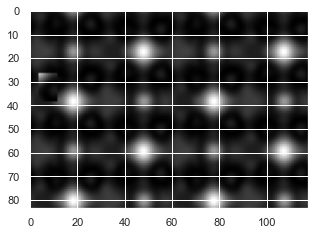

In [46]:
my_array = val_x[12]
plt.figure(figsize = (5,5))
plt.imshow(my_array, cmap = 'gray')
plt.show()

In [53]:
def build_cnn_model():
    #Stuff
    filters = 32
    filter_size = 3
    pool_size = 2
    epoch_number = 50
    my_models = []
    my_val_accuracy = []
    my_val_loss = []

    # Build the model
    # print(f'4 Layers Results: ')
    # model = Sequential([
    #   Conv2D(filters, filter_size, input_shape = (84, 118, 1)), 
    #   MaxPooling2D(pool_size = pool_size),
    #   Conv2D(filters * 2, filter_size),
    #   MaxPooling2D(pool_size = pool_size),
    #   Conv2D(filters * 4, filter_size),
    #   MaxPooling2D(pool_size = pool_size),
    #   Conv2D(filters * 8, filter_size),
    #   MaxPooling2D(pool_size = pool_size),
    #   Flatten(),
    #   Dense(2, activation = 'sigmoid')
    # ])

    model = Sequential()
    model.add(Conv2D(8, (3, 3), input_shape=(84, 118, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model.
    model.compile(loss='binary_crossentropy',
                      optimizer='nadam',
                      metrics=['accuracy'])

    print(model.summary())
    return model

model = build_cnn_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 82, 116, 8)        80        
_________________________________________________________________
batch_normalization_9 (Batch (None, 82, 116, 8)        32        
_________________________________________________________________
activation_15 (Activation)   (None, 82, 116, 8)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 41, 58, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 39, 56, 16)        1168      
_________________________________________________________________
batch_normalization_10 (Batc (None, 39, 56, 16)        64        
_________________________________________________________________
activation_16 (Activation)   (None, 39, 56, 16)       

In [49]:
# Fit model
history = model.fit(
    x = train_gen,
    epochs=500,
    steps_per_epoch=len(train_window_images)//64,
    validation_data=(val_x, val_y),
    validation_batch_size=int(len(val_x)*0.50))

my_models.append(model)
my_val_accuracy.append(history.history['val_accuracy'][-1])
my_val_loss.append(history.history['val_loss'][-1])

Epoch 1/500
175/175 [==============================] - 25s 145ms/step - loss: 0.6414 - accuracy: 0.6187 - val_loss: 1.0764 - val_accuracy: 0.5000
Epoch 2/500
175/175 [==============================] - 27s 152ms/step - loss: 0.1307 - accuracy: 0.9575 - val_loss: 1.7707 - val_accuracy: 0.5000
Epoch 3/500
175/175 [==============================] - 27s 153ms/step - loss: 0.0578 - accuracy: 0.9833 - val_loss: 0.2710 - val_accuracy: 0.8906
Epoch 4/500
175/175 [==============================] - 27s 152ms/step - loss: 0.0464 - accuracy: 0.9868 - val_loss: 0.1688 - val_accuracy: 0.9424
Epoch 5/500
175/175 [==============================] - 26s 150ms/step - loss: 0.0346 - accuracy: 0.9901 - val_loss: 0.0520 - val_accuracy: 0.9912
Epoch 6/500
175/175 [==============================] - 26s 149ms/step - loss: 0.0294 - accuracy: 0.9925 - val_loss: 0.0987 - val_accuracy: 0.9717
Epoch 7/500
175/175 [==============================] - 26s 149ms/step - loss: 0.0296 - accuracy: 0.9921 - val_loss: 0.0420 -

In [52]:
f_path = os.path.join(proj_dir, 'trained_models', 'cutpaste_0noise_500epochs.SavedModel')
model.save(f_path, save_format='tf')

INFO:tensorflow:Assets written to: /Users/philip/Documents/GitHub/cutpaste-AFIT/trained_models/cutpaste_0noise_500epochs.SavedModel/assets


In [ ]:
f_name_types = os.path.join(raw_data_dir, 'test_defect_types.p')
f_name_windows = os.path.join(raw_data_dir, 'test_windows.p')
f_name_labels = os.path.join(raw_data_dir, 'test_labels.p')

test_types = pickle.load(open(f_name_types, "rb"))
test_windows = pickle.load(open(f_name_windows, "rb"))
test_labels = pickle.load(open(f_name_labels, "rb"))

Predictions
[0 0 0 ... 1 1 1]
Real Labels
[0 0 0 ... 1 1 1]
Accuracy
0.9112


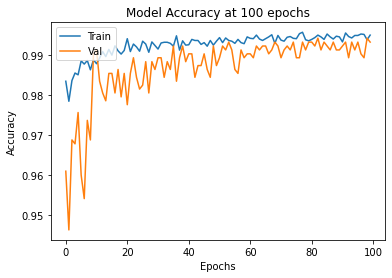

<Figure size 720x720 with 0 Axes>

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy at 100 epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.figure(figsize = (10,10))
plt.show

predictions = model.predict(test_windows)
pred_class = np.around(predictions)
pred_class = pred_class.reshape(-1).astype(int)
print("Predictions")
print(pred_class)
print("Real Labels")
print(test_labels)
print("Accuracy")
total_acc_100 = np.sum(pred_class == test_labels)/2500
print(total_acc_100)

type1_100 = test_types[0] + " Accuracy"
type1Acc_100 = np.sum(pred_class[0:500] == test_labels[0:500])/500
type2_100 = test_types[500] + " Accuracy"
type2Acc_100 = np.sum(pred_class[500:1000] == test_labels[500:1000])/500
type3_100 = test_types[1001] + " Accuracy"
type3Acc_100 = (np.sum(pred_class[1000:1500] == test_labels[1000:1500])/500)
type4_100 = test_types[1501] + " Accuracy"
type4Acc_100 = (np.sum(pred_class[1500:2000] == test_labels[1500:2000])/500)
type5_100 = (test_types[2001] + "Accuracy")
type5Acc_100 = (np.sum(pred_class[2000:2500] == test_labels[2000:2500])/500)


# Train CutPaste CNN w/ noise(wt=0.08)

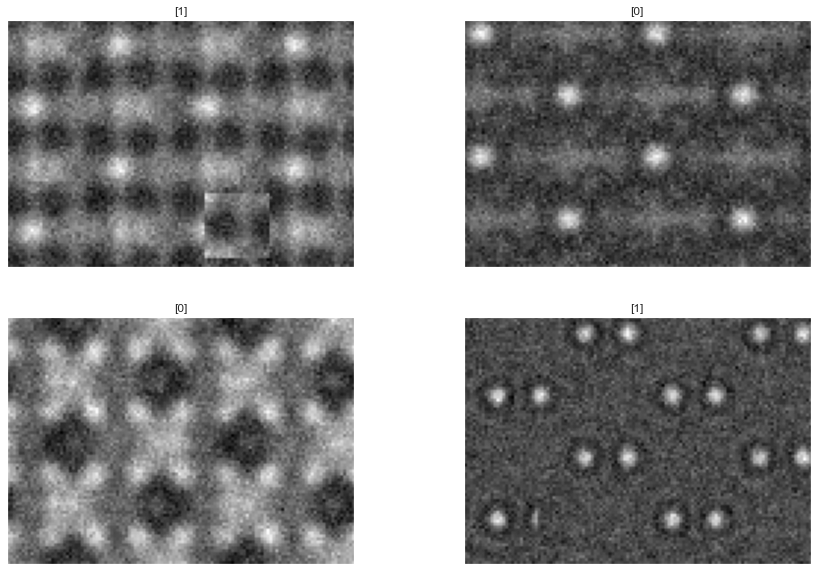

In [88]:
train_gen = generateImages(train_window_images, 32, 32, noise=True)
val_gen = generateImages(test_window_images, 512, 512, noise=True)
# train_gen_noisy = generateImagesNoise(train_window_images, 32, 32)
# val_gen_noisy = generateImages(test_window_images, 512, 512)
val_x, val_y = next(val_gen)
train_x_sample, train_y_sample = next(train_gen)
# val_x_noisy, val_y_noisy = next(val_gen_noisy)

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.imshow(train_x_sample[0], cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title(train_y_sample[0])

plt.subplot(2,2,2)
plt.imshow(train_x_sample[1], cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title(train_y_sample[1])

plt.subplot(2,2,3)
plt.imshow(train_x_sample[2], cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title(train_y_sample[2])

plt.subplot(2,2,4)
plt.imshow(train_x_sample[3], cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title(train_y_sample[3])

plt.show()

In [91]:
# model = build_cnn_model()

# Fit model
history = model.fit(
    x = train_gen,
    epochs=500,
    steps_per_epoch=len(train_window_images)//64,
    validation_data=(val_x, val_y),
    validation_batch_size=int(len(val_x)*0.50))

Epoch 1/500
175/175 [==============================] - 32s 183ms/step - loss: 0.2040 - accuracy: 0.9201 - val_loss: 0.2053 - val_accuracy: 0.9238
Epoch 2/500
175/175 [==============================] - 33s 189ms/step - loss: 0.2077 - accuracy: 0.9196 - val_loss: 0.2043 - val_accuracy: 0.9180
Epoch 3/500
175/175 [==============================] - 40s 230ms/step - loss: 0.2040 - accuracy: 0.9204 - val_loss: 0.1990 - val_accuracy: 0.9258
Epoch 4/500
175/175 [==============================] - 37s 210ms/step - loss: 0.2016 - accuracy: 0.9214 - val_loss: 0.1991 - val_accuracy: 0.9229
Epoch 5/500
175/175 [==============================] - 37s 209ms/step - loss: 0.2077 - accuracy: 0.9231 - val_loss: 0.1984 - val_accuracy: 0.9258
Epoch 6/500
175/175 [==============================] - 34s 194ms/step - loss: 0.2117 - accuracy: 0.9162 - val_loss: 0.2321 - val_accuracy: 0.9053
Epoch 7/500
175/175 [==============================] - 37s 210ms/step - loss: 0.2075 - accuracy: 0.9164 - val_loss: 0.2154 -

In [92]:
f_path = os.path.join(proj_dir, 'trained_models', 'cutpaste_08noise_1000epochs.SavedModel')
model.save(f_path, save_format='tf')

INFO:tensorflow:Assets written to: /Users/philip/Documents/GitHub/cutpaste-AFIT/trained_models/cutpaste_08noise_1000epochs.SavedModel/assets


# Test Code

In [52]:
model = Sequential()
model.add(GaussianNoise(stddev = random.uniform(0,0.1), input_shape = (84,118,1)))
model.add(Conv2D(8, (3, 3), input_shape=(84, 118, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(32))
#     model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Compile the model.
model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['accuracy'])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_3 (GaussianNo (None, 84, 118, 1)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 82, 116, 8)        80        
_________________________________________________________________
batch_normalization_21 (Batc (None, 82, 116, 8)        32        
_________________________________________________________________
activation_35 (Activation)   (None, 82, 116, 8)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 41, 58, 8)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 39, 56, 16)        1168      
_________________________________________________________________
batch_normalization_22 (Batc (None, 39, 56, 16)       

In [58]:
# Fit model
history = model.fit(
    train_gen,
    epochs = 100,
    steps_per_epoch=len(train_window_images)//64,
    validation_data=(val_x_noisy, val_y_noisy),
    validation_batch_size=int(len(val_x)*0.50))

my_models.append(model)
my_val_accuracy.append(history.history['val_accuracy'][-1])
my_val_loss.append(history.history['val_loss'][-1])
model.save(os.path.join(notebooks_dir, 'cutpaste_200epochs_Noisy.SavedModel'))

Epoch 1/100
175/175 [==============================] - 37s 213ms/step - loss: 0.0566 - accuracy: 0.9834 - val_loss: 0.1408 - val_accuracy: 0.9609
Epoch 2/100
175/175 [==============================] - 37s 213ms/step - loss: 0.0790 - accuracy: 0.9784 - val_loss: 0.1629 - val_accuracy: 0.9463
Epoch 3/100
175/175 [==============================] - 37s 213ms/step - loss: 0.0592 - accuracy: 0.9836 - val_loss: 0.0966 - val_accuracy: 0.9688
Epoch 4/100
175/175 [==============================] - 37s 213ms/step - loss: 0.0502 - accuracy: 0.9854 - val_loss: 0.1001 - val_accuracy: 0.9678
Epoch 5/100
175/175 [==============================] - 37s 210ms/step - loss: 0.0500 - accuracy: 0.9850 - val_loss: 0.0840 - val_accuracy: 0.9756
Epoch 6/100
175/175 [==============================] - 37s 210ms/step - loss: 0.0426 - accuracy: 0.9885 - val_loss: 0.1468 - val_accuracy: 0.9600
Epoch 7/100
175/175 [==============================] - 37s 211ms/step - loss: 0.0452 - accuracy: 0.9877 - val_loss: 0.1365 -

Predictions
[0 0 0 ... 1 1 1]
Real Labels
[0 0 0 ... 1 1 1]
Accuracy
0.9112


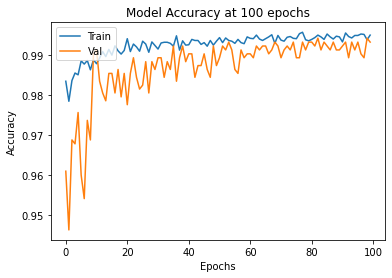

<Figure size 720x720 with 0 Axes>

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy at 100 epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.figure(figsize = (10,10))
plt.show

predictions = model.predict(test_windows)
pred_class = np.around(predictions)
pred_class = pred_class.reshape(-1).astype(int)
print("Predictions")
print(pred_class)
print("Real Labels")
print(test_labels)
print("Accuracy")
total_acc_100_n = np.sum(pred_class == test_labels)/2500
print(total_acc_100_n)

type1_100_n = test_types[0] + " Accuracy"
type1Acc_100_n = np.sum(pred_class[0:500] == test_labels[0:500])/500
type2_100_n = test_types[500] + " Accuracy"
type2Acc_100_n = np.sum(pred_class[500:1000] == test_labels[500:1000])/500
type3_100_n = test_types[1001] + " Accuracy"
type3Acc_100_n = (np.sum(pred_class[1000:1500] == test_labels[1000:1500])/500)
type4_100_n = (test_types[1501] + "Accuracy")
type4Acc_100_n = (np.sum(pred_class[1500:2000] == test_labels[1500:2000])/500)
type5_100_n = (test_types[2001], "Accuracy")
type5Acc_100_n = (np.sum(pred_class[2000:2500] == test_labels[2000:2500])/500)


In [69]:
d = {type1_100 : [type1Acc_100, type1Acc_100_n], type2_100: [type2Acc_100, type2Acc_100_n], type3_100: [type3Acc_100, type3Acc_100_n], type4_100: [type4Acc_100, type4Acc_100_n], type5_100: [type5Acc_100, type5Acc_100_n], 'Total Accuracy' : [total_acc_100, total_acc_100_n]}
df_filename = os.path.join(raw_data_dir, 'RealDefectAccuracyData')
df = pd.DataFrame(data = d, index = ['100 Epochs w/o Noise', '100 Epochs w/ Noise'])
df.to_csv(df_filename, index = False)
df.to_excel(df_filename + ".xlsx", index = False)
display(df)

,nondefect Accuracy,swap Accuracy,enlarged Accuracy,brightened Accuracy,roundAccuracy,Total Accuracy
100 Epochs w/o Noise,1.0,0.556,1.0,1.0,1.0,0.9112
100 Epochs w/ Noise,1.0,0.556,1.0,1.0,1.0,0.9112
